# Attention Mechnism
- Seq2Seq의 입력 Sequence를 Encoder에 의해 하나의 Context Vector로 변환하고, Decoder가 이 Vector를 이용해 출력 Sequence구성
- 단점: 
    - Context Vector의 고정된 크기(columns -> Matrix의 행과 열)로 인해 정보 손실
    - 긴 Sequence의 경우, RNN 계열 모델들의 장기기억소실/기울기 소실 문제들이 발생
- Attention Mechanism : Decoder에서 출력 단어를 생성할 때, 단어를 예측하는 매 시점(Time Step)마다, Encoder의 전체 입력 문장의 정보를 반영하여 출력
- 해당 시점에서 예측해야 할 단어와 연관있는 입력 단어의 부분을 좀 더 집중(Attention)하여 출력
- 작동: 
    - 모든 단어 쌍에 대한 Key value형태의 유사도 분석을 수행
    - 해당 유사도를 이용하여 Attention Score계산
    - Attention Score: 현재 Decoder의 특정 t시점에서 단어를 예측하기 위해, Encoder의 각 시점의 값이 Decoder의 각 시점의 값과 얼마나 유사한지를 계산
    - Attention Score를 이용해 분포추정을 실시 -> 출력 단계에 좀 더 유사한 단어 쌍이 생성되도록 유도

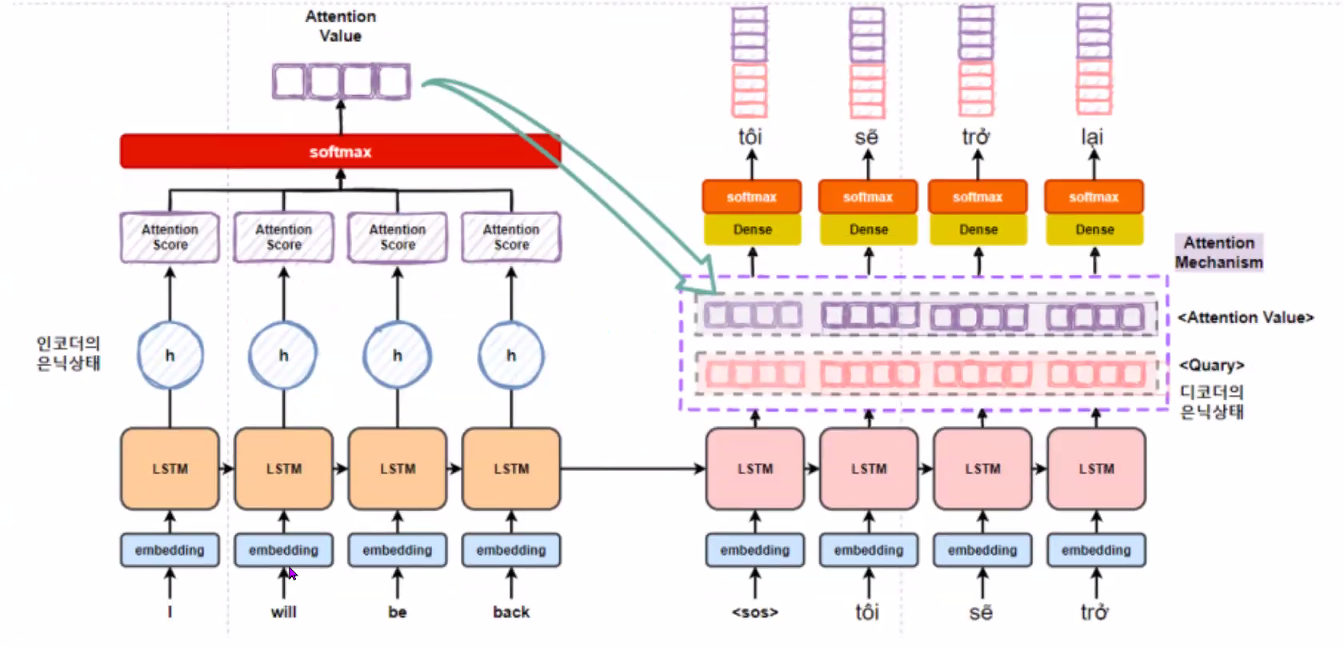

# 트랜스포머 (Transformer)
- Attention Mechanism을 응용하여, 이전의 RNN, LSTM모델에서 Sequence 단위의 데이터를 순차적으로 처리하는 것과 달리, 전체 Sequence를 한번에 처리
- 구성요소
    - Self - Attention : 하나의 입력 Sequence내 각 위치의 토큰이 Sequence내 다른 위치 토큰과 얼마나 관련이 있는지를 계산
        - 문장 내 단어간의 등장 순서/ 관계 파악
    - Multi-Head Attention : Self-Attention 층이 병렬로 반복적으로 처리되며 다양한 표현(Subspace)에서 정보를 추출
        - 위치 정보가 처리된 문장의 정보를 처리
    - Position Encoding: Attention으로 구성된 모델에서 각 Sequence의 순서 정보를 유지하기 위해, 순서 정보를 가진 Position Encoding을 수행
    

In [ ]:
# !pip install tensorflow_datasets

In [9]:
import pandas as pd
import numpy as np
import re
import tensorflow_datasets as tfds
import tensorflow as tf
df1 = pd.read_csv('39_Data.csv')

In [14]:
# 특수 문자에 대해 띄어쓰기를 수행 -> 토큰화
# ?,!. 기호 앞뒤로 공백을 추가
questions = [re.sub(r"([?.!,])", r" \1", x).strip() for x in df1['Q']]
answer = [re.sub(r"([?.!,])", r" \1", x).strip() for x in df1['A']]

In [21]:
# 서브토크나이져 : 훈련 데이터에 없는 새로운 단어가 등장해도 그 단어를 구성하는 문자를 분해하여(서브워드) 처리 할 수 있음
token_model = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answer, target_vocab_size= 2**13)

In [ ]:
token_model.subwords

In [23]:
# 만들어진 토큰 수
token_model.vocab_size

8176

In [27]:
# SOS와 EOS를 단어 사전에 추가
# SOS와 EOS가 들어갈 Index 부여
START_TOKEN, END_TOKEN = [token_model.vocab_size], [token_model.vocab_size + 1]

# SOS와 EOS를 추가하기 위해 단어 사전의 공간을 늘림
VOCAB_SIZE = token_model.vocab_size+2

In [30]:
# 앞서 구성한 서브토크나이저를 이용해 Text to Sequence
print(questions[0])
token_model.encode(questions[0])

12시 땡 !


[7914, 4205, 3058, 41]

In [33]:
# 숫자를 문자로 변환
seq1 = [5766,611,3509,141,685,3747,849]
token_model.decode(seq1)

'가보발비슷데 가끔 건조걸로 '

- 전체 데이터를 이용한 Text to Sequence와 Padding작업을 수행

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
# 토큰화 + 패딩
def token_pad(text):
    text_list = [] # 토큰화 + 패딩 결과를 담을 변수를 선언
    for i in text:
        sent1 = START_TOKEN + token_model.encode(i) + END_TOKEN # 문장을 Encoding 후, SOS번호와 EOS 번호를 추가
        text_list.append(sent1)

    return pad_sequences(text_list, maxlen=40, padding = 'post')

In [40]:
questions_out = token_pad(questions)
answers_out = token_pad(answer)

- 앞서 처리된 질문/답변 행렬을 데이터 파일로 지정

In [42]:
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE

- 교사 강요(Teacher Forcing) : 모델의 현재 출력을 다음 시점의 입력으로 사용하는 대신, 실제 목표 분장의 현재 시점의 데이터를 다음 시점의 입력으로 사용
    - '나는 고양이를 정말 좋아해' 문장에서 '고양이' 단어 가 나올 때, '정말'이라는 단어가 등장하게 학습이 되어야 하지만,
    '강아지'와 같은 전혀 다른 단어들이 출현
    - 학습 단계에서 이전 단어 다음의 단어를 정확하게 맞추지 못해도, 다음 단어의 입력을 강제로 정답을 알려주며 학습을 수행

In [45]:
# Tensorflow의 Dataset을 이용해서 배치 사이즈로 데이터를 묶음
batch_size = 64


dataset = Dataset.from_tensor_slices((
    # 디코더의 입력/ 마지막 패딩 토큰을 제거
    {'input':questions_out, 'dec_input':answers_out[:,:-1]},
    # 디코더의 출력에서 EOS를 제거
    {'outputs' : answers_out[:,1:]}
))

# 데이터셋을 빠르게 로드하여 Epoch 수행
dataset1 = dataset.cache()
# 데이터를 Batch Size에 맞게 묶음
dataset2 = dataset1.batch(batch_size)
# 데이터의 로딩 시간을 줄이기 위해, 데이터를 미리 메모리에 로딩
dataset3 = dataset2.prefetch(AUTOTUNE)

In [48]:
save_path = '/chatbot_dataset'
dataset3.save(save_path)

# 포지셔널 인코딩 (Positional Encoding)

- Transformer 모델의 입력층으로 사용되는 Layer
- 기본적인 RNN 모델은 단어를 순차적으로 받아서 처리하기 때문에, 문장 내 단어의 순서가 처리되는 정보가 존재
- 그러나 Transformer 모델은 데이터를 한번에 처리하기 때문에, 문장 내 단어의 순서 정보가 소실될 수 있음
- ![image1](https://wikidocs.net/images/page/31379/transformer2.PNG)

- Positional Encoding 기법으로 단어의 위치정보를 Matrix로 형태로 변환하여 학습을 수행
- sin 함수와 cos 함수를 활용하여, 단어의 순서 정보를 Matrix 형태로 단어 Matrix와 함께 전달

- ![image1](https://wikidocs.net/images/page/31379/transformer6_final.PNG)
![image2](https://wikidocs.net/images/page/31379/transformer7.PNG)

# Transformer Attention

- Attention : 특정 Layer층에서 출력되는 매 시점 마다, 전체 문장을 다시 참조하여 출력
- 유사도를 계산하여, 가장 유사도가 높은 문장의 단어 벡터를 찾아 다음 Layer 반영
- Attention 구성 요소
  - Query : 현재 처리 중인 단어에 대한 표현
  - Key : 비교 대상이 되는 단어들의 표현
  - Value : 각 Query

In [7]:
import transformer_chatbot

ModuleNotFoundError: No module named 'transformer_chatbot'